# 0. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import resample
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# 1. Load Data

Your data should be placed in the directory where this jupyter notebook is located

In [2]:
data = pd.read_csv('./H1.csv')
print('data shape : {}'.format(data.shape))
print('columns : \n {}'.format(list(data.columns)))

data shape : (40060, 31)
columns : 
 ['IsCanceled', 'LeadTime', 'ArrivalDateYear', 'ArrivalDateMonth', 'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth', 'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children', 'Babies', 'Meal', 'Country', 'MarketSegment', 'DistributionChannel', 'IsRepeatedGuest', 'PreviousCancellations', 'PreviousBookingsNotCanceled', 'ReservedRoomType', 'AssignedRoomType', 'BookingChanges', 'DepositType', 'Agent', 'Company', 'DaysInWaitingList', 'CustomerType', 'ADR', 'RequiredCarParkingSpaces', 'TotalOfSpecialRequests', 'ReservationStatus', 'ReservationStatusDate']


In [3]:
data.head(10)

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,342,2015,July,27,1,0,0,2,0,...,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,0,737,2015,July,27,1,0,0,2,0,...,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,0,7,2015,July,27,1,0,1,1,0,...,No Deposit,NULL,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,0,13,2015,July,27,1,0,1,1,0,...,No Deposit,304,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,0,14,2015,July,27,1,0,2,2,0,...,No Deposit,240,NULL,0,Transient,98.0,0,1,Check-Out,2015-07-03
5,0,14,2015,July,27,1,0,2,2,0,...,No Deposit,240,NULL,0,Transient,98.0,0,1,Check-Out,2015-07-03
6,0,0,2015,July,27,1,0,2,2,0,...,No Deposit,NULL,NULL,0,Transient,107.0,0,0,Check-Out,2015-07-03
7,0,9,2015,July,27,1,0,2,2,0,...,No Deposit,303,NULL,0,Transient,103.0,0,1,Check-Out,2015-07-03
8,1,85,2015,July,27,1,0,3,2,0,...,No Deposit,240,NULL,0,Transient,82.0,0,1,Canceled,2015-05-06
9,1,75,2015,July,27,1,0,3,2,0,...,No Deposit,15,NULL,0,Transient,105.5,0,0,Canceled,2015-04-22


# 2. Exploratory Data Analysis
This part mostly overlaps with what has been done in our team project. I'll just recap the important variables.<br>You may skip to the third section if you have already seen our team project EDA!

## 2.1 How long have you been waiting?
Seems to have significant influence to IsCanceled

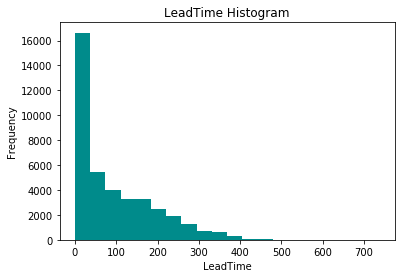

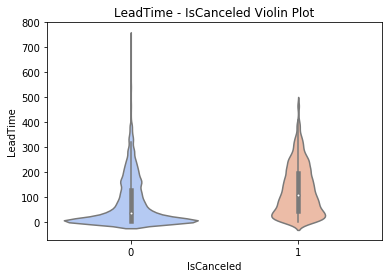

In [4]:
plt.hist(data['LeadTime'], color='darkcyan', bins=20)
plt.title('LeadTime Histogram')
plt.xlabel('LeadTime')
plt.ylabel('Frequency')
plt.show()
plt.close()

sns.set_palette(sns.color_palette("coolwarm", 2))
sns.violinplot(x="IsCanceled", y='LeadTime', data=data)
plt.title('LeadTime - IsCanceled Violin Plot')
plt.show()
plt.close()

## 2.2 Time-dependent Variables
* There seems to be an increasing trend of cancellation from year 2015 to 2017, but due to lack of historical data regarding years, it would be safe not to use this variable. Otherwise, the model will regard the cancellation will continue to increase in time, which might be a dangerous assumption to make.
* There seems to be a seasonal difference. Mainly, spring and summer months and weeks tend to have more cancellations
* The Day variable does not seem to have much effect.

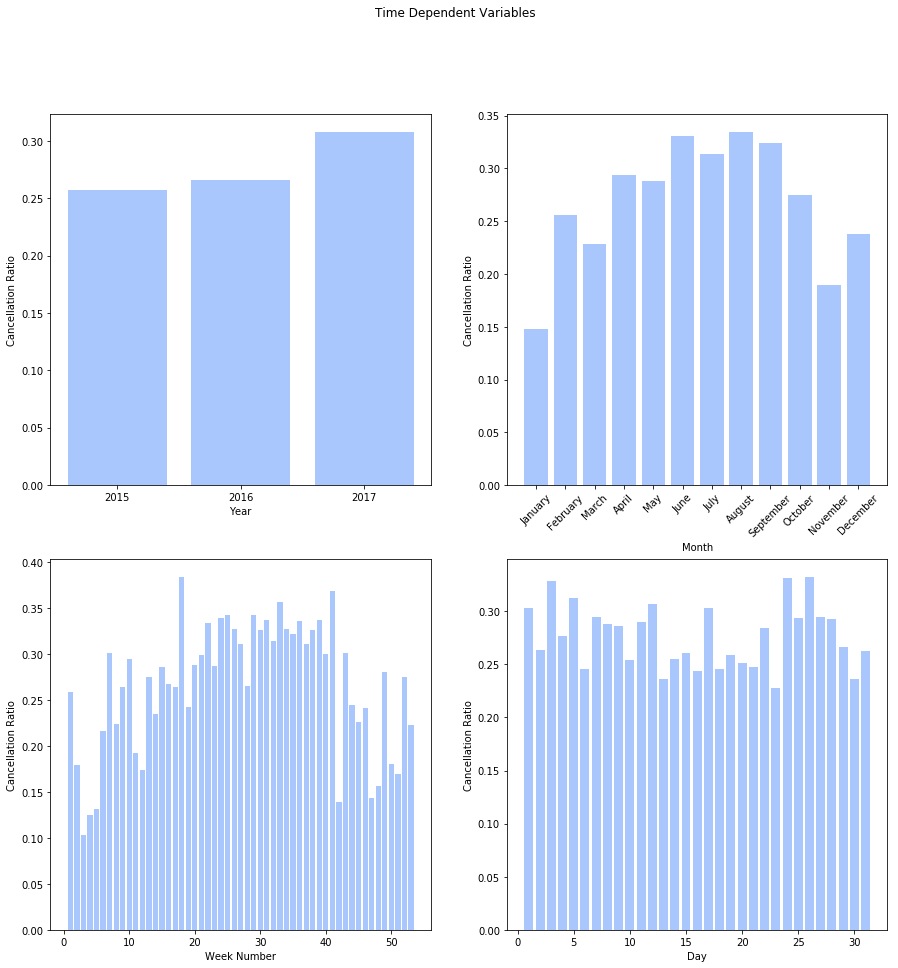

In [5]:
yearly_cancel_rate = data.groupby(data['ArrivalDateYear'])['IsCanceled'].mean()
monthly_cancel_rate = data.groupby(data['ArrivalDateMonth'])['IsCanceled'].mean()
monthly_cancel_rate = monthly_cancel_rate[['January','February','March','April','May','June','July','August',
                           'September','October','November','December']]
weekly_cancel_rate = data.groupby(data['ArrivalDateWeekNumber'])['IsCanceled'].mean()
daily_cancel_rate = data.groupby(data['ArrivalDateDayOfMonth'])['IsCanceled'].mean()

fig, ax = plt.subplots(2,2,figsize=(15,15))
fig.suptitle('Time Dependent Variables')
ax[0,0].bar(yearly_cancel_rate.index, yearly_cancel_rate)
ax[0,0].set_xticks([2015,2016,2017])
ax[0,0].set_xlabel('Year')
ax[0,0].set_ylabel('Cancellation Ratio')

ax[0,1].bar(monthly_cancel_rate.index, monthly_cancel_rate)
ax[0,1].tick_params(axis='x',rotation=45)
ax[0,1].set_xlabel('Month')
ax[0,1].set_ylabel('Cancellation Ratio')


ax[1,0].bar(weekly_cancel_rate.index, weekly_cancel_rate)
ax[1,0].set_xlabel('Week Number')
ax[1,0].set_ylabel('Cancellation Ratio')

ax[1,1].bar(daily_cancel_rate.index, daily_cancel_rate)
ax[1,1].set_xlabel('Day')
ax[1,1].set_ylabel('Cancellation Ratio')
plt.show()
plt.close()

## 2.3 Number of People
Generally, the more people you have, the more cancellation there may be. The difference is subtle, so we might as well simply aggregate the numbers of adults, children, and babies and make a new variable

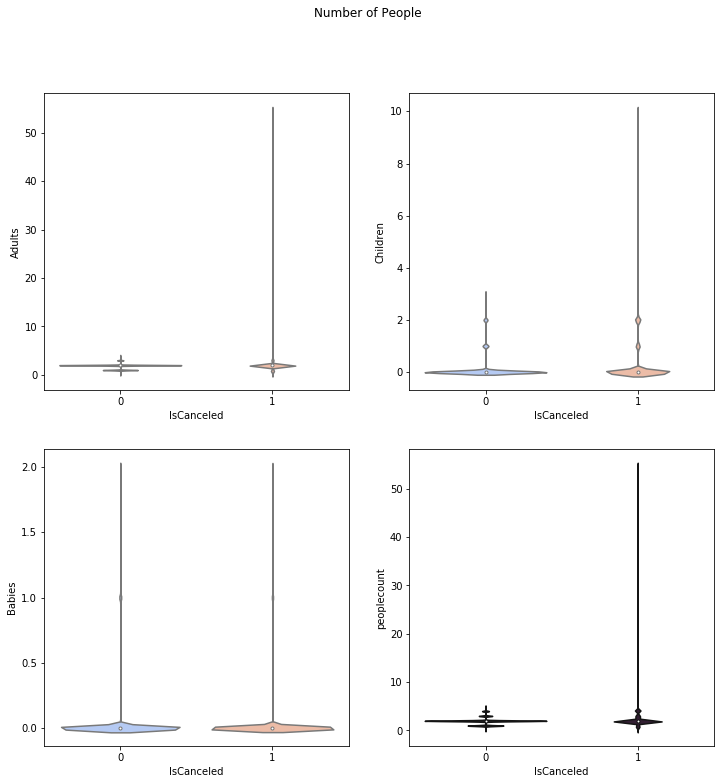

In [6]:
data['peoplecount'] = data['Adults'] + data['Children'] + data['Babies']
fig, ax = plt.subplots(2,2,figsize=(12,12))
fig.suptitle('Number of People')
sns.set_palette(sns.color_palette("coolwarm", 2))
sns.violinplot(ax=ax[0,0],x="IsCanceled", y='Adults', data=data)
sns.violinplot(ax=ax[0,1],x="IsCanceled", y='Children', data=data)
sns.violinplot(ax=ax[1,0],x="IsCanceled", y='Babies', data=data)
sns.set_palette(sns.dark_palette("purple"))
sns.violinplot(ax=ax[1,1],x="IsCanceled", y='peoplecount', data=data)
plt.show()
plt.close()

## 2.4 Meals
Interestingly, the meal type does seem to have effect.

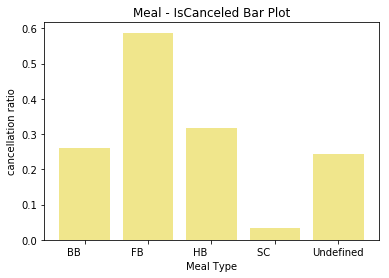

Meal
BB           30005
FB             754
HB            8046
SC              86
Undefined     1169
Name: Meal, dtype: int64


In [7]:
meal = data.groupby(data['Meal']).mean()['IsCanceled']
plt.bar(x=meal.index, height=meal.values, color='khaki')
plt.title('Meal - IsCanceled Bar Plot')
plt.xlabel('Meal Type')
plt.ylabel('cancellation ratio')
plt.show()
plt.close()

print(data['Meal'].groupby(data['Meal']).count())

## 2.5 Distribution Channel
People who have booked their rooms via Traveling Agents and Tour Operators had slightly greater

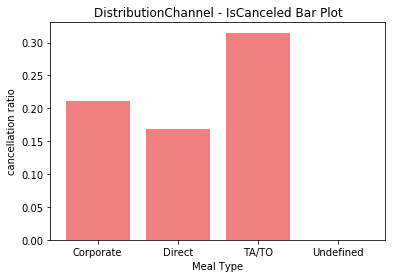

In [8]:
distchan = data.groupby(data['DistributionChannel']).mean()['IsCanceled']
plt.bar(x=distchan.index, height=distchan.values, color='lightcoral')
plt.title('DistributionChannel - IsCanceled Bar Plot')
plt.xlabel('Meal Type')
plt.ylabel('cancellation ratio')
plt.show()
plt.close()

## 2.6 Have you been here before?
If you have been here before, that means that you were satisfied with the services you've receieved the last time you were here. Therefore, a smaller rate of cancellations

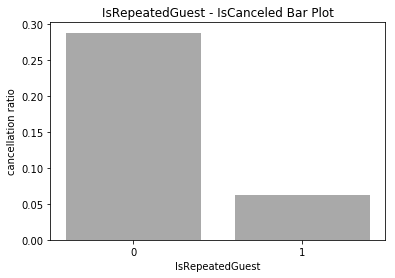

In [9]:
rep = data.groupby(data['IsRepeatedGuest']).mean()['IsCanceled']
plt.bar(x=rep.index, height=rep.values, color='darkgray')
plt.xticks([0,1])
plt.title('IsRepeatedGuest - IsCanceled Bar Plot')
plt.xlabel('IsRepeatedGuest')
plt.ylabel('cancellation ratio')
plt.show()
plt.close()

## 2.7 Past Cancellations
Of course... People don't change. If you have had cancellations, the more likely you'll cancel this time too :(

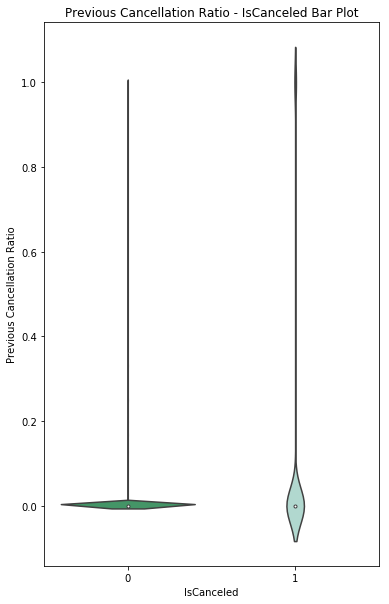

In [10]:
# With the PreeviousCancellations and PreviusBookingsNotCanceled variable, we may compute the ratio
cancel_rto = data['PreviousCancellations'] / (data['PreviousCancellations'] + data['PreviousBookingsNotCanceled'])
cancel_rto = cancel_rto.fillna(0)
data['Previous Cancellation Ratio'] = cancel_rto


sns.set_palette(sns.color_palette("BuGn_r", 2))
fig, ax = plt.subplots(1,1,figsize=(6,10))
plt.title('Previous Cancellation Ratio - IsCanceled Bar Plot')
sns.violinplot(x="IsCanceled", y='Previous Cancellation Ratio', data=data)
plt.show()
plt.close()

## 2.8 Reserved Room == Assigned Room ?

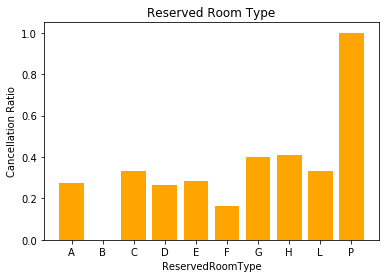

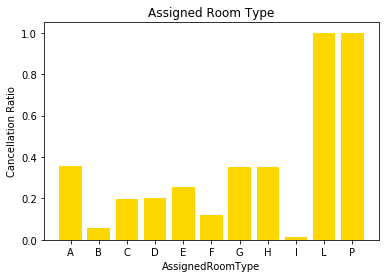

AssignedRoomType
A                   17046
B                     159
C                    2214
D                   10339
E                    5638
F                    1733
G                    1853
H                     712
I                     363
L                       1
P                       2
Name: AssignedRoomType, dtype: int64


In [11]:
roomtype = data.groupby(data['ReservedRoomType']).mean()['IsCanceled']
plt.bar(x=['A','B','C','D','E','F','G','H','L','P'], height=roomtype.values, color='orange')
plt.xticks()
plt.title('Reserved Room Type')
plt.xlabel('ReservedRoomType')
plt.ylabel('Cancellation Ratio')
plt.show()
plt.close()

roomtype = data.groupby(data['AssignedRoomType']).mean()['IsCanceled']
plt.bar(x=['A','B','C','D','E','F','G','H','I','L','P'], height=roomtype.values, color='gold')
plt.xticks()
plt.title('Assigned Room Type')
plt.xlabel('AssignedRoomType')
plt.ylabel('Cancellation Ratio')
plt.show()
plt.close()

print(data['AssignedRoomType'].groupby(data['AssignedRoomType']).count())

P and L does seem to be significant, but considering just a few occurrence of them in the dataset, we'd better ignore them.

Rather, we might want to take a look at the relation between IsCanceled and the whether the assigned room is different from what was reserved.

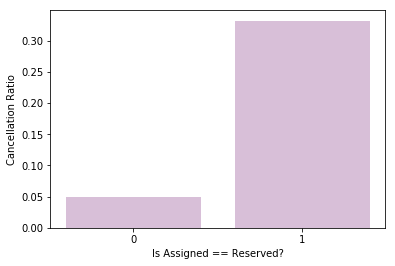

In [12]:
# check if assigned room has changed
data['SameRoomType'] = (data['ReservedRoomType'] == data['AssignedRoomType']).apply(lambda x: int(x))

sameroom = data.groupby(data['SameRoomType']).mean()['IsCanceled']
plt.bar(x=sameroom.index, height=sameroom.values, color='thistle')
plt.xticks([0,1])
plt.xlabel('Is Assigned == Reserved?')
plt.ylabel('Cancellation Ratio')
plt.show()
plt.close()

## 2.9 Customer Type
Generally, transient customer(s) will tend to cancel more often.

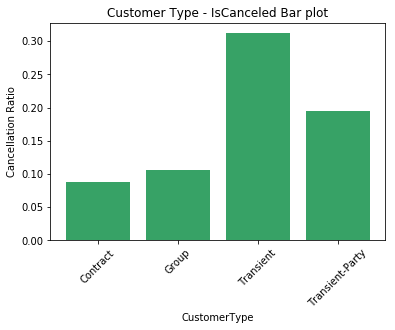

CustomerType
Contract            1776
Group                284
Transient          30209
Transient-Party     7791
Name: IsCanceled, dtype: int64


In [13]:
custtype = data.groupby(data['CustomerType']).mean()['IsCanceled']
plt.bar(x=custtype.index, height=custtype.values)
plt.xticks(rotation=45)
plt.title('Customer Type - IsCanceled Bar plot')
plt.xlabel("CustomerType")
plt.ylabel('Cancellation Ratio')
plt.show()
plt.close()
print(data.groupby(data['CustomerType']).count()['IsCanceled'])

## 2.10 Parking Space Requested
Maybe there are some significant correlations between requested parking spaces and the number of people coming?

In [14]:
data[['RequiredCarParkingSpaces', 'peoplecount']].corr()

,RequiredCarParkingSpaces,peoplecount
RequiredCarParkingSpaces,1.000000,0.039676
peoplecount,0.039676,1.000000


Nope, ABSOLUTELY no correlation.

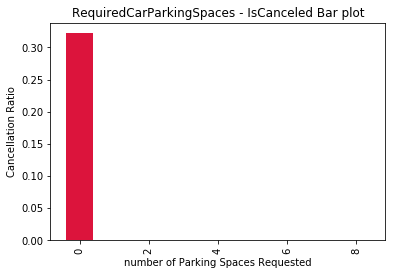

In [15]:
parking = data.groupby(data['RequiredCarParkingSpaces']).mean()['IsCanceled']
plt.bar(x=parking.index, height=parking.values, color='crimson')
plt.xticks(rotation='vertical')
plt.title('RequiredCarParkingSpaces - IsCanceled Bar plot')
plt.xlabel('number of Parking Spaces Requested')
plt.ylabel('Cancellation Ratio')
plt.show()
plt.close()

Hmm.. Interesting. If you requested for any amount of parking spaces, you did not cancel your reservation. This is somewhat reasonable. Requesting for parking spaces may signify you are definitely scheduled to come.

For simplicity, maybe we should make this into a binary variable : 0 parking space / non-zero parking space

# 3. Preprocessing

In [16]:
# aggregate number of people per reservation
data['peoplecount'] = data['Adults'] + data['Children'] + data['Babies']

# compute previous cancel ratio
cancel_rto = data['PreviousCancellations'] / (data['PreviousCancellations'] + data['PreviousBookingsNotCanceled'])
cancel_rto = cancel_rto.fillna(0)
data['Previous Cancellation Ratio'] = cancel_rto

# check if assigned room type is different from the reserved room type
data['SameRoomType'] = (data['ReservedRoomType'] == data['AssignedRoomType']).apply(lambda x: int(x))

# month to season
spr_sum = ['March','April','May','June','July','August']  # 1
fal_win = ['September','October','November','December','January','February']  # 0
data['ArrivalSeason'] = data['ArrivalDateMonth'].apply(lambda x : int(x in spr_sum))

# Reduce Marketsegment
ones = ['Online TA','Groups']
data['MarketSegENC'] = data['MarketSegment'].apply(lambda x : int(x in ones))

# Deposit type to binary : Non-refundable or Not
data['NonRefundable'] = data['DepositType'].apply(lambda x : int(x == 'Non Refund'))

# Transient Customers or Not
ones = ['Transient','Transient-Party']
data['TransientCust'] = data['CustomerType'].apply(lambda x : int(x in ones))

# Required Parking Space or Not
data['NeedParking'] = data['RequiredCarParkingSpaces'].apply(lambda x : int(x != 0))

In [17]:
# Feature Selection
usecols = ['IsCanceled','LeadTime','ArrivalSeason','peoplecount','Meal','MarketSegENC','DistributionChannel',
           'IsRepeatedGuest','Previous Cancellation Ratio','SameRoomType','NonRefundable','DaysInWaitingList',
           'TransientCust','NeedParking']
data = data[usecols]
data.head()

,IsCanceled,LeadTime,ArrivalSeason,peoplecount,Meal,MarketSegENC,DistributionChannel,IsRepeatedGuest,Previous Cancellation Ratio,SameRoomType,NonRefundable,DaysInWaitingList,TransientCust,NeedParking
0,0,342,1,2,BB,0,Direct,0,0.0,1,0,0,1,0
1,0,737,1,2,BB,0,Direct,0,0.0,1,0,0,1,0
2,0,7,1,1,BB,0,Direct,0,0.0,0,0,0,1,0
3,0,13,1,1,BB,0,Corporate,0,0.0,1,0,0,1,0
4,0,14,1,2,BB,1,TA/TO,0,0.0,1,0,0,1,0


In [18]:
# To dummy variables
data_oh = pd.get_dummies(data, columns=['Meal','DistributionChannel'])
data_oh.head()

,IsCanceled,LeadTime,ArrivalSeason,peoplecount,MarketSegENC,IsRepeatedGuest,Previous Cancellation Ratio,SameRoomType,NonRefundable,DaysInWaitingList,...,NeedParking,Meal_BB,Meal_FB,Meal_HB,Meal_SC,Meal_Undefined,DistributionChannel_Corporate,DistributionChannel_Direct,DistributionChannel_TA/TO,DistributionChannel_Undefined
0,0,342,1,2,0,0,0.0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
1,0,737,1,2,0,0,0.0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
2,0,7,1,1,0,0,0.0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,0,13,1,1,0,0,0.0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
4,0,14,1,2,1,0,0.0,1,0,0,...,0,1,0,0,0,0,0,0,1,0


In [19]:
# Split X, y
X = data_oh.iloc[:,1:]
y = data_oh.iloc[:,0]
print('X shape : {}'.format(X.shape))
print('y shape : {}'.format(y.shape))

X shape : (40060, 20)
y shape : (40060,)


# 4. Original Model : Decision Tree Classifier
I reimplemented the original model that has been demonstrated in our team project

In [20]:
dt = DecisionTreeClassifier(
    criterion='entropy',
)

tr_accs = []
te_accs = []
kfold = KFold(n_splits=10)
for idx, (tr_idx, te_idx) in enumerate(kfold.split(X)) :
    trainX = X.iloc[tr_idx, :]
    testX = X.iloc[te_idx, :]
    trainy = y.iloc[tr_idx]
    testy = y.iloc[te_idx]
    
    dt.fit(trainX, trainy)
    tr_pred = dt.predict(trainX)
    te_pred = dt.predict(testX)
    
    tr_acc = accuracy_score(tr_pred, trainy)
    te_acc = accuracy_score(te_pred, testy)
    tr_accs.append(tr_acc)
    te_accs.append(te_acc)
    print('Fold {0} : Train Accuracy = {1:.4f}'.format(idx+1, tr_acc))
    print('Fold {0} : Test Accuracy = {1:.4f}'.format(idx+1, te_acc))
    print()

print('\tK Fold Accuracy Mean : {0:.4f}'.format(np.mean(te_accs)))
print('\tK Fold Accuracy Standard Deviation : {0:.4f}'.format(np.std(te_accs)))

Fold 1 : Train Accuracy = 0.8855
Fold 1 : Test Accuracy = 0.6363

Fold 2 : Train Accuracy = 0.8979
Fold 2 : Test Accuracy = 0.4131

Fold 3 : Train Accuracy = 0.9037
Fold 3 : Test Accuracy = 0.2646

Fold 4 : Train Accuracy = 0.8802
Fold 4 : Test Accuracy = 0.6782

Fold 5 : Train Accuracy = 0.8673
Fold 5 : Test Accuracy = 0.8984

Fold 6 : Train Accuracy = 0.8699
Fold 6 : Test Accuracy = 0.8682

Fold 7 : Train Accuracy = 0.8774
Fold 7 : Test Accuracy = 0.7871

Fold 8 : Train Accuracy = 0.8738
Fold 8 : Test Accuracy = 0.7688

Fold 9 : Train Accuracy = 0.8744
Fold 9 : Test Accuracy = 0.7644

Fold 10 : Train Accuracy = 0.8810
Fold 10 : Test Accuracy = 0.6977

	K Fold Accuracy Mean : 0.6777
	K Fold Accuracy Standard Deviation : 0.1886


The following are some problems we can see in the original models above.<br>
* Overfitting is observed in many folds - test accuracy is way lower than train accuracy<br>
* There seems to be severe imbalance in label proportions.<br>
* unstable test accuracies across folds.

# 5. Improvement Measures

## 5.1 Dimension Reduction
We have many options. We may use the PCA or even a special kind of neural network called 'AutoEncoders' to reduce the dimension of the data. But since we were working on Decision Trees, we may take advantage of the feature importances. With the feature importance, we may reduce the dimension while preserving interpretability. By reducing the dimension, we'll be able to have a simpler model that performs similarly, or even better at generalization, with a lower computation cost.

In [21]:
trainx, testx, trainy, testy = train_test_split(X, y, test_size=0.25, random_state=1234)
print('Train X shape : {}'.format(trainx.shape))
print('Train y shape : {}'.format(trainy.shape))
print('Test X shape : {}'.format(testx.shape))
print('Test y shape : {}'.format(testy.shape))

Train X shape : (30045, 20)
Train y shape : (30045,)
Test X shape : (10015, 20)
Test y shape : (10015,)


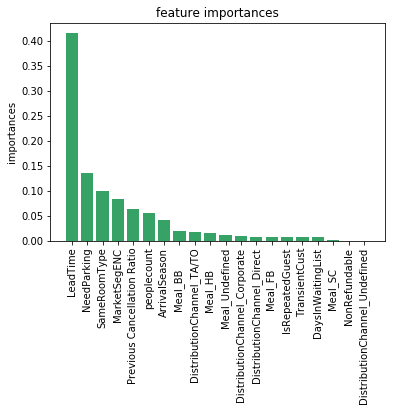

In [22]:
# Check which feature plays an important role
dt = DecisionTreeClassifier(
    criterion='entropy',
)
dt.fit(trainx, trainy)

fi = pd.DataFrame({
    'features' : list(trainx.columns),
    'feature_importances' : dt.feature_importances_
})

fi = fi.sort_values(by='feature_importances', ascending=False)
plt.bar(height=fi['feature_importances'], x=fi['features'])
plt.title('feature importances')
plt.ylabel('importances')
plt.xticks(rotation=90)
plt.show()
plt.close()

Important features seem to be :<br>
'LeadTime','NeedParking','SameRoomType','MarketSegENC','Previous Cancellation Ratio','peoplecount','ArrivalSeason'<br>
Now let's reduce the number of variables by using only the variables listed above.

In [23]:
data_short = data[['LeadTime','NeedParking','SameRoomType','MarketSegENC','Previous Cancellation Ratio',
                   'peoplecount','ArrivalSeason','IsCanceled']]
X = data_short.iloc[:,:-1]
y = data_short.iloc[:,-1:]
data_short.head(10)

,LeadTime,NeedParking,SameRoomType,MarketSegENC,Previous Cancellation Ratio,peoplecount,ArrivalSeason,IsCanceled
0,342,0,1,0,0.0,2,1,0
1,737,0,1,0,0.0,2,1,0
2,7,0,0,0,0.0,1,1,0
3,13,0,1,0,0.0,1,1,0
4,14,0,1,1,0.0,2,1,0
5,14,0,1,1,0.0,2,1,0
6,0,0,1,0,0.0,2,1,0
7,9,0,1,0,0.0,2,1,0
8,85,0,1,1,0.0,2,1,1
9,75,0,1,0,0.0,2,1,1


## 5.2 Upsampling
We can see that the label proportion is seriously imbalanced. I will apply upsampling so as to equalize the number of instances for each label

In [24]:
trainx, testx, trainy, testy = train_test_split(X, y, test_size=0.25, random_state=1234)
print('Train X shape : {}'.format(trainx.shape))
print('Train y shape : {}'.format(trainy.shape))
print('Test X shape : {}'.format(testx.shape))
print('Test y shape : {}'.format(testy.shape))

print('portion of label 1 in Train set : {0:.4f}'.format(np.mean(trainy['IsCanceled'])))

Train X shape : (30045, 7)
Train y shape : (30045, 1)
Test X shape : (10015, 7)
Test y shape : (10015, 1)
portion of label 1 in Train set : 0.2807


In [25]:
def upsample(trainx, trainy):
    label0_len = len(trainy[trainy['IsCanceled']==0])
    label1_len = len(trainy[trainy['IsCanceled']==1])
    num_to_smpl = label0_len - label1_len

    X_cat = pd.concat([trainx, trainy], axis=1)
    X_cat_label0 = X_cat[X_cat['IsCanceled']==0]
    X_cat_label1 = X_cat[X_cat['IsCanceled']==1]
    X_cat_upsmpled = resample(X_cat_label1, n_samples=num_to_smpl)

    X_upsampled = pd.concat([X_cat_label0, X_cat_label1, X_cat_upsmpled], axis=0).sample(frac=1)

    trainx = X_upsampled.iloc[:,:-1]
    trainy = X_upsampled.iloc[:,-1:]
    return trainx, trainy

trainx, trainy = upsample(trainx, trainy)

## 5.3 Pruning
We did apply pruning in our team project, but since I have reduced the number of variables, maybe a little bit more of pruning might be needed. We'll try to find the optimal value for max_depth and min_smples_split by utilizing a grid search

In [26]:
max_depths = [3,4,5,6,7,8,9,10]
min_samples_splits = [2,4,8,16,32]

best_md = None
best_mss = None
max_acc = -1
for md, mss in itertools.product(max_depths, min_samples_splits):
    dt_improved = DecisionTreeClassifier(
        criterion='entropy',
        max_depth=md,
        min_samples_split=mss
    )
    dt_improved.fit(trainx, trainy)
    tr_pred = dt_improved.predict(trainx)
    te_pred = dt_improved.predict(testx)
    
    if accuracy_score(te_pred, testy) > max_acc :
        best_md = md
        best_mss = mss
        max_acc = accuracy_score(te_pred, testy)
    
#     print('Max Depth - {}  /  Min Samples Split - {}'.format(md, mss))
#     print('Train Accuracy = {}'.format(accuracy_score(tr_pred, trainy)))
#     print('Test Accuracy = {}'.format(accuracy_score(te_pred, testy)))
#     print()
print('best Max Depth = {}'.format(best_md))
print('best Min Samples Split = {}'.format(best_mss))

best Max Depth = 5
best Min Samples Split = 2


## 5.4 Ensembling
A single decision tree may lead to overfitting. So by ensembling many different decision trees, we might get a better prediction result. The model is called Random Forest, and I plan to use the module in scikit learn.

In [27]:
rf = RandomForestClassifier(
    criterion='entropy',
    max_depth=4,
    min_samples_split=2,
    n_estimators=301 # an odd number for tie breaker
)

In [28]:
rf.fit(trainx, trainy)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=301, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [29]:
tr_pred = rf.predict(trainx)
te_pred = rf.predict(testx)
print('Train Accuracy = {}'.format(accuracy_score(tr_pred, trainy)))
print('Test Accuracy = {}'.format(accuracy_score(te_pred, testy)))
print(classification_report(te_pred, testy))

Train Accuracy = 0.7664969921332716
Test Accuracy = 0.762556165751373
              precision    recall  f1-score   support

           0       0.76      0.90      0.82      6142
           1       0.78      0.54      0.64      3873

   micro avg       0.76      0.76      0.76     10015
   macro avg       0.77      0.72      0.73     10015
weighted avg       0.77      0.76      0.75     10015



# 6. Evaluation

## 6.1 K-Cross Validation
To better assess model performance, I checked with the K-Cross validation, and to be more conservative, I left out the test set for final evaluation. A separate validation set was extracted from the train set to use it for model optimization

In [30]:
# This is just a dummy example. We will iteratively split the train data in the K-cross validation
trainX, valX, trainY, valY = train_test_split(trainx, trainy, test_size=0.1, random_state=1111)
print('Train X shape : {}'.format(trainX.shape))
print('Train y shape : {}'.format(trainY.shape))
print('Validation X shape : {}'.format(valX.shape))
print('Validation y shape : {}'.format(valY.shape))
print('Test X shape : {}'.format(testx.shape))
print('Test y shape : {}'.format(testy.shape))

Train X shape : (38898, 7)
Train y shape : (38898, 1)
Validation X shape : (4322, 7)
Validation y shape : (4322, 1)
Test X shape : (10015, 7)
Test y shape : (10015, 1)


In [31]:
trainx, testx, trainy, testy = train_test_split(X, y, test_size=0.25, random_state=1234)

tr_accs = []
val_accs = []
kfold = KFold(n_splits=10)
for idx, (tr_idx, val_idx) in enumerate(kfold.split(trainx)) :
    trainX = trainx.iloc[tr_idx, :]
    valX = trainx.iloc[val_idx, :]
    trainY = trainy.iloc[tr_idx]
    valY = trainy.iloc[val_idx]
    trainX, trainY = upsample(trainX, trainY)
    
    rf.fit(trainX, trainY)
    tr_pred = rf.predict(trainX)
    val_pred = rf.predict(valX)
    
    tr_acc = accuracy_score(tr_pred, trainY)
    val_acc = accuracy_score(val_pred, valY)
    tr_accs.append(tr_acc)
    val_accs.append(val_acc)
    print('Fold {0} : Train Accuracy = {1:.4f}'.format(idx+1, tr_acc))
    print('Fold {0} : Validation Accuracy = {1:.4f}'.format(idx+1, val_acc))
    print()

print('K Fold Accuracy Mean : {0:.4f}'.format(np.mean(val_accs)))
print('K Fold Accuracy Standard Deviation : {0:.4f}'.format(np.std(val_accs)))

Fold 1 : Train Accuracy = 0.7637
Fold 1 : Validation Accuracy = 0.7574

Fold 2 : Train Accuracy = 0.7632
Fold 2 : Validation Accuracy = 0.7547

Fold 3 : Train Accuracy = 0.7679
Fold 3 : Validation Accuracy = 0.7614

Fold 4 : Train Accuracy = 0.7657
Fold 4 : Validation Accuracy = 0.7498

Fold 5 : Train Accuracy = 0.7678
Fold 5 : Validation Accuracy = 0.7557

Fold 6 : Train Accuracy = 0.7651
Fold 6 : Validation Accuracy = 0.7587

Fold 7 : Train Accuracy = 0.7616
Fold 7 : Validation Accuracy = 0.7696

Fold 8 : Train Accuracy = 0.7658
Fold 8 : Validation Accuracy = 0.7720

Fold 9 : Train Accuracy = 0.7587
Fold 9 : Validation Accuracy = 0.7230

Fold 10 : Train Accuracy = 0.7622
Fold 10 : Validation Accuracy = 0.7610

K Fold Accuracy Mean : 0.7563
K Fold Accuracy Standard Deviation : 0.0128


## 6.1 Performance on the Test set

In [32]:
trainx, trainy = upsample(trainx, trainy)

rf.fit(trainx, trainy)

tr_pred = rf.predict(trainx)
te_pred = rf.predict(testx)
print('Train Accuracy = {}'.format(accuracy_score(tr_pred, trainy)))
print('Test Accuracy = {}'.format(accuracy_score(te_pred, testy)))
print(classification_report(te_pred, testy))

Train Accuracy = 0.7644146228597871
Test Accuracy = 0.7627558662006989
              precision    recall  f1-score   support

           0       0.76      0.90      0.82      6140
           1       0.78      0.54      0.64      3875

   micro avg       0.76      0.76      0.76     10015
   macro avg       0.77      0.72      0.73     10015
weighted avg       0.77      0.76      0.75     10015

